In [1]:
import cv2, numpy, virtualenvwrapper, math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from scipy.ndimage import label
from PIL import Image
import pytesseract
%matplotlib inline

In [2]:
def find_largest_area(image):
    largest_area = 0
    largest_c = None
    temp_image = image.copy()
    mask = np.zeros(temp_image.shape[:2])
    contours,hierarchy = cv2.findContours(temp_image, 1, 2)
    for c in contours:
        area = cv2.contourArea(c)
        x,y,w,h = cv2.boundingRect(c)
        aspect_ratio = float(w)/h
        if largest_area < area and (aspect_ratio < 2.5) and (aspect_ratio > 1.2):
            largest_area = area
            largest_c = c
    
    peri = cv2.arcLength(largest_c, True)
    approx_c = cv2.approxPolyDP(largest_c, peri, True)
    cv2.drawContours(mask, [largest_c], -1, 0, -1)

    (x,y,w,h) = cv2.boundingRect(largest_c)
    return (x,y,w,h)

In [66]:
# removing small ilands
def remove_small_ilands(image, iterations = 1, rate = [0.7, 1.5], bothside = False):
    temp_image = image.copy()
    for i in range(iterations):
        labels, numL = None, None
        temp_image_inv = cv2.threshold(temp_image,127,255,cv2.THRESH_BINARY_INV)[1]
        labels, numL = label(temp_image_inv)

        area_array = [np.sum(labels == i) for i in xrange(1, numL+1)]
        avg = np.average(area_array)
        new_mask = np.zeros(temp_image.shape[:2],np.uint8)
        for ind, entry in enumerate(area_array):
            if entry < rate[0] * avg:
                new_mask[np.array(labels==(ind+1)).nonzero()] = 255
            if bothside == True and entry > rate[1] * avg:
                new_mask[np.array(labels==(ind+1)).nonzero()] = 255
        temp_image = cv2.bitwise_or(temp_image, new_mask)
        
    return temp_image

In [4]:
# horizonal dilate
def h_dilate(image, size = 40):
    mask = np.zeros(image.shape[:2],np.uint8)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j] != 0:
                mask[i,max(size/2,j-size/2):min(j+size/2,image.shape[1]-size/2)] = image[i,j]
    return mask

In [5]:
# horizonal largest strip
def h_largest_strip(image):
    area_removed_inv = cv2.threshold(image,127,255,cv2.THRESH_BINARY_INV)[1]
    v_his = [sum(area_removed_inv[i,:]) for i in range(image.shape[0])]
    ind, left, right, window_size = 0, 0, 0, 0
    while ind < len(v_his):
        peak = max(v_his)
        if v_his[ind] > 0.1 * peak:
            left = ind
            while ind < len(v_his) and (v_his[ind] > 0.1 * peak):
                ind += 1
            right = ind
            if abs(right - left) > window_size:
                max_window = [right, left]
                window_size = abs(right - left)
        ind += 1
    return max_window

# Step 0 -  Loading Image

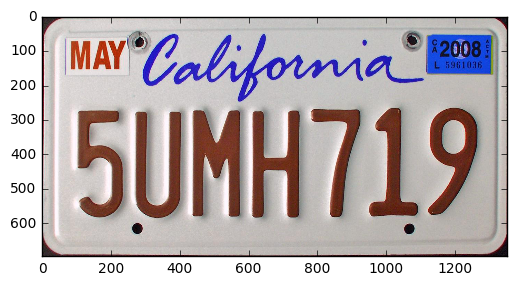

In [70]:
raw_img = cv2.imread('lpr_test1.jpeg')
plt.imshow(raw_img,cmap='gray',vmin=0,vmax=255)

# Step 1 - Preprocessing

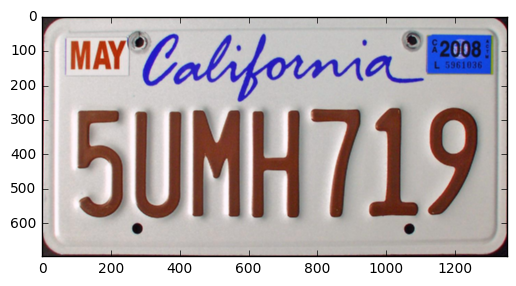

In [71]:
# apply gaussian low pass filter to remove high frequency noise
kernel = np.ones((5,5),np.float32) / 25
blured = cv2.filter2D(raw_img, -1, kernel)
plt.imshow(blured,cmap='gray',vmin=0,vmax=255)

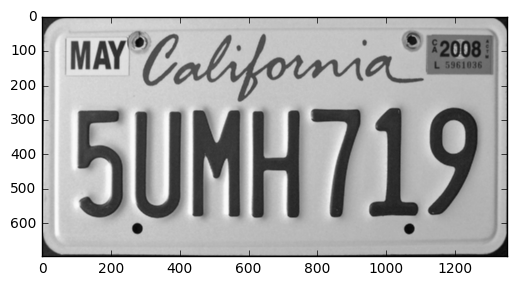

In [72]:
# change color space to gray scale 
grayed = cv2.cvtColor(blured, cv2.COLOR_BGR2GRAY)
plt.imshow(grayed,cmap='gray',vmin=0,vmax=255)

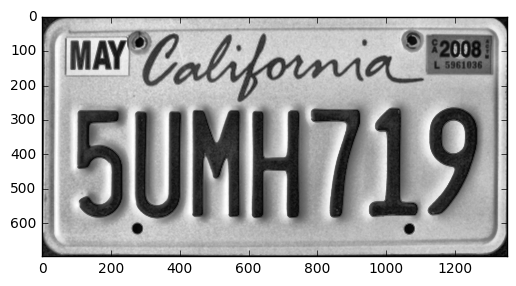

In [73]:
# histogram equalization, sharpen the image for next step
# equalized = cv2.equalizeHist(grayed)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
equalized = clahe.apply(grayed)
plt.imshow(equalized,cmap='gray',vmin=0,vmax=255)

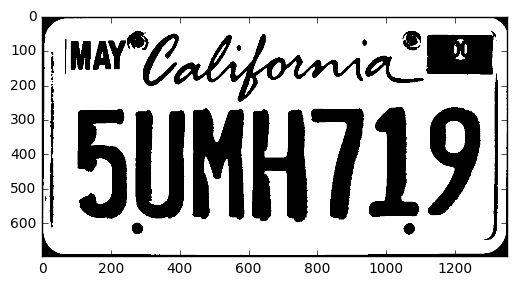

In [74]:
# inverted binary thresholding
ret,thresh2 = cv2.threshold(equalized,127,255,cv2.ADAPTIVE_THRESH_MEAN_C)
plt.imshow(thresh2,cmap='gray',vmin=0,vmax=255)

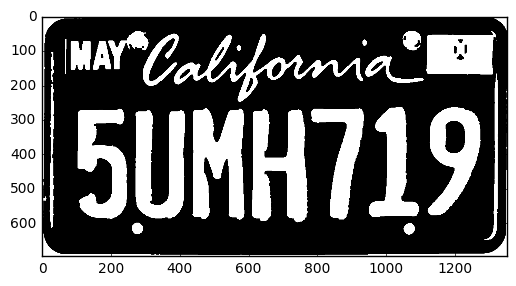

In [75]:
# invert image
ret,thresh2_inverted = cv2.threshold(thresh2,127,255,cv2.THRESH_BINARY_INV)
thresh2_inverted = cv2.morphologyEx(thresh2_inverted, cv2.MORPH_CLOSE, kernel)
plt.imshow(thresh2_inverted,cmap='gray',vmin=0,vmax=255)

# Step 2 - Locate the largest rectangle-like countour

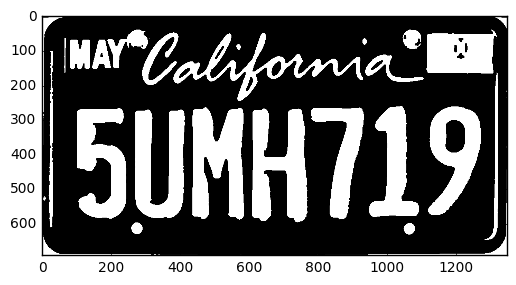

In [76]:
# find the largest contour area which has its bounding rectangle with reasonable width/length ratio
(x,y,w,h) = find_largest_area(thresh2)
raw_plate_area = thresh2_inverted[y:y+h, x:x+w]
plt.imshow(raw_plate_area, cmap='gray',vmin=0,vmax=255)

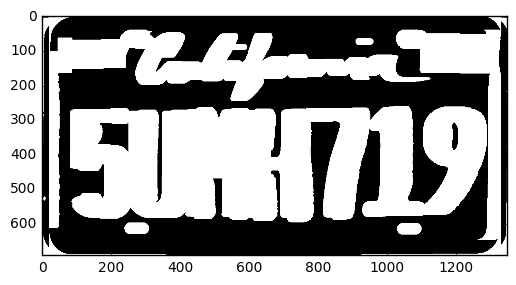

In [77]:
h_mask = h_dilate(raw_plate_area)
refined_p_area = cv2.bitwise_or(raw_plate_area, h_mask)
plt.imshow(refined_p_area,cmap='gray',vmin=0,vmax=255)

# Step 3 - Refining Plate Area, removing small ilands

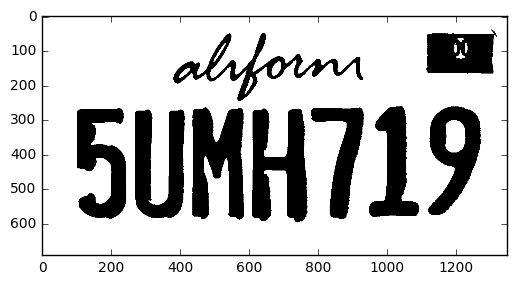

In [78]:
area_removed = remove_small_ilands(thresh2[y:y+h, x:x+w],iterations=2)
plt.imshow(area_removed,cmap='gray',vmin=0,vmax=255)

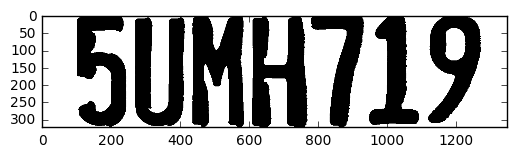

In [79]:
c = cv2.threshold(area_removed,127,255,cv2.THRESH_BINARY_INV)[1]
# plt.plot([sum(area_removed_inv[i,:]) for i in range(area_removed.shape[0])])
# print min(max_window), max(max_window)
max_window = h_largest_strip(area_removed)
striped_area = area_removed[min(max_window):max(max_window),:]
plt.imshow(striped_area,cmap='gray',vmin=0,vmax=255)

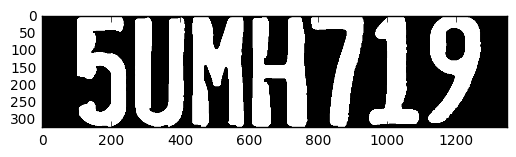

In [80]:
# another round of cleanning ilands
striped_area_inv = cv2.threshold(striped_area,127,255,cv2.THRESH_BINARY_INV)[1]
striped_area_inv_opening = cv2.morphologyEx(striped_area_inv, cv2.MORPH_OPEN, kernel)
striped_area_inv_closing = cv2.morphologyEx(striped_area_inv_opening, cv2.MORPH_CLOSE, kernel)
striped_area_inv_removed = remove_small_ilands(striped_area_inv_closing, iterations=1, rate = [0.3, 1.5], bothside = True)
plt.imshow(striped_area_inv_closing,cmap='gray',vmin=0,vmax=255)

# Step 4 - OCR

In [81]:
img = Image.fromarray(striped_area_inv_closing)
txt = pytesseract.image_to_string(img)
print "Plate number is: ", txt

Plate number is:  SUMH719
